In [ ]:
import os

def count_images_per_class(dataset_path):
    """
    Count number of images in each class inside a dataset folder.
    dataset_path should contain subfolders like 'train', 'val', 'test' (optional).
    """
    for split in ["train", "valid", "test"]:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            continue

        print(f"\n Split: {split}")
        for class_name in os.listdir(split_path):
            class_dir = os.path.join(split_path, class_name)
            if not os.path.isdir(class_dir):
                continue

            # Count image files (jpg, png, jpeg)
            image_count = sum(
                1 for f in os.listdir(class_dir) 
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            )

            print(f"  🔹 {class_name}: {image_count} images")

if __name__ == "__main__":
    DATASET_PATH = r"C:\Users\abdal\Downloads\merged_dataset"  # <-- change to your dataset folder
    count_images_per_class(DATASET_PATH)


In [ ]:
from ultralytics import YOLO
import os

def train_model(data_path, epochs=50, imgsz=224, batch=32, device=0):
    """
    Train a YOLO classification model
    """
    model = YOLO("yolov8s-cls.pt")  

    results = model.train(
        data=data_path,   # dataset path with train/ and valid/ folders
        epochs=epochs,    # number of epochs
        imgsz=imgsz,      # image size
        batch=batch,      # batch size
        device=device     # GPU index (0 for first GPU, or "cpu")
    )

    print("✅ Training finished")
    print("Best model is saved at:", results.save_dir / "weights" / "best.pt")


if __name__ == "__main__":
    DATA_PATH = r"C:\Users\abdal\Downloads\merged_dataset"
    train_model(DATA_PATH, epochs=50, imgsz=224, batch=32)


In [ ]:
from ultralytics import YOLO

def evaluate_model(weights_path, data_path):
    """
    Evaluate the trained YOLO classification model
    """
    model = YOLO(weights_path)
    metrics = model.val(data=data_path)

    print("📊 Evaluation results:")
    print(f"Top-1 Accuracy: {metrics.top1:.2f}")
    print(f"Top-5 Accuracy: {metrics.top5:.2f}")

if __name__ == "__main__":
    WEIGHTS = r"C:\Users\abdal\Downloads\Compressed\Cat Emotions.v1i.multiclass\runs\classify\train23\weights/best.pt"
    DATA_PATH = r"C:\Users\abdal\Downloads\merged_dataset"
    evaluate_model(WEIGHTS, DATA_PATH)


In [ ]:
from ultralytics import YOLO

# Class mapping
CLASS_MAP = {
    0: 'attentive',
    1: 'no clear emotion recognizable',
    2: 'relaxed',
    3: 'sad',
    4: 'uncomfortable',
    5: 'Angry',
    6: 'Disgusted',
    7: 'Happy',
    8: 'Normal',
    9: 'Scared',
    10: 'Surprised'
}

def predict_image(weights_path, image_path):
    """
    Run inference on a new image using the trained model
    """
    model = YOLO(weights_path)
    results = model.predict(image_path)

    probs = results[0].probs
    top1 = probs.top1
    top1_conf = float(probs.top1conf)

    print(f"✅ Predicted class: {CLASS_MAP[top1]} ({top1_conf*100:.2f}%)\n")
    print("Top-5 Predictions:")
    for idx, conf in zip(probs.top5, probs.top5conf):
        print(f"- {CLASS_MAP[idx]}: {float(conf)*100:.2f}%")

if __name__ == "__main__":
    WEIGHTS = r"C:\Users\abdal\Downloads\Compressed\Cat Emotions.v1i.multiclass\runs\classify\train23\weights/best.pt"
    IMAGE = r"C:\Users\abdal\Downloads\images.jpg"
    predict_image(WEIGHTS, IMAGE)


In [1]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np

# --- Configuration ---
# Path to your trained cat emotion classification model
CLASSIFIER_PATH = r'C:\Users\ziads\OneDrive\Desktop\python\best.pt'

# Define the list of class names in the correct order
CLASS_NAMES = [
    'Angry', 'Disgusted', 'Happy', 'Normal', 'Scared', 'Surprised',
    'attentive', 'no clear emotion recognizable', 'relaxed', 'sad', 'uncomfortable'
]

# --- Model Loading ---
# Load the general-purpose YOLOv8 object detection model (pretrained on COCO)
# This model will find the cats in the frame.
try:
    object_detector = YOLO('yolov8n.pt')
    print("General object detector (yolov8n.pt) loaded successfully.")
except Exception as e:
    print(f"Error loading general object detector: {e}")

# Load your custom-trained YOLOv8 classification model
# This model will classify the emotion of a cropped cat image.
try:
    emotion_classifier = YOLO(CLASSIFIER_PATH)
    print(f"Emotion classifier ({CLASSIFIER_PATH}) loaded successfully.")
except Exception as e:
    print(f"Error loading emotion classifier: {e}")

# Check if CUDA (GPU) is available and print the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

General object detector (yolov8n.pt) loaded successfully.
Emotion classifier (C:\Users\ziads\OneDrive\Desktop\python\best.pt) loaded successfully.
Using device: cpu


In [2]:
def process_frame(frame):
    """
    This function processes a single frame to detect cats and classify their emotion.
    """
    if 'object_detector' not in globals() or 'emotion_classifier' not in globals():
        print("Models not loaded. Cannot process frame.")
        return frame

    # 1. DETECT CATS IN THE FRAME
    # The 'cat' class in the COCO dataset has index 15. We'll filter for it.
    # We set confidence threshold to 0.4 to filter out weak detections.
    detections = object_detector(frame, classes=[15], conf=0.4, verbose=False)

    # Loop over each detected cat
    for result in detections:
        # The 'boxes' attribute contains the bounding box information
        for box in result.boxes:
            # Get coordinates [x1, y1, x2, y2]
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # 2. CROP THE DETECTED CAT
            # We add a small padding to ensure we capture the whole cat
            padding = 10
            cat_crop = frame[max(0, y1-padding):min(frame.shape[0], y2+padding),
                             max(0, x1-padding):min(frame.shape[1], x2+padding)]

            # Check if the crop is valid
            if cat_crop.size == 0:
                continue

            # 3. CLASSIFY THE EMOTION OF THE CROPPED CAT
            emotion_results = emotion_classifier(cat_crop, verbose=False)

            # Get the top prediction
            if emotion_results:
                top_prediction = emotion_results[0].probs.top1
                top_confidence = emotion_results[0].probs.top1conf
                emotion_label = CLASS_NAMES[top_prediction]
                label_text = f"{emotion_label}: {top_confidence:.2f}"
            else:
                label_text = "Unknown"

            # 4. DRAW THE BOUNDING BOX AND LABEL ON THE ORIGINAL FRAME
            # Draw the bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Draw the label background
            (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1 - h - 15), (x1 + w, y1), (0, 255, 0), -1)

            # Put the label text
            cv2.putText(frame, label_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    return frame

In [3]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import PIL.Image

def analyze_video_file(video_path):
    """
    Opens and analyzes a video file, displaying frames inside the Jupyter cell.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file at {video_path}")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("End of video.")
                break

            # Process the frame
            processed_frame = process_frame(frame)

            # Convert frame from BGR (OpenCV format) to RGB (Matplotlib format)
            frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)

            # Display the frame in the notebook
            clear_output(wait=True) # Clear the previous frame
            img = PIL.Image.fromarray(frame_rgb)
            display(img)

    except KeyboardInterrupt:
        print("Interrupted by user.")
    finally:
        cap.release()
        print("Video analysis stopped.")


def analyze_live_camera():
    """
    Opens the default camera and analyzes the live feed, displaying frames in the Jupyter cell.
    """
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame from camera.")
                break

            # Process the frame
            processed_frame = process_frame(frame)
            
            # Convert frame from BGR (OpenCV format) to RGB (Matplotlib format)
            frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            
            # Display the frame in the notebook
            clear_output(wait=True) # Clear the previous frame
            img = PIL.Image.fromarray(frame_rgb)
            display(img)
            
    except KeyboardInterrupt:
        print("Interrupted by user.")
    finally:
        cap.release()
        print("Camera feed stopped.")

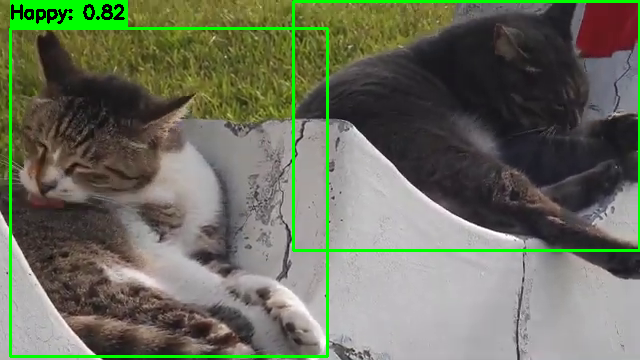

End of video.
Video analysis stopped.


In [10]:
# (Cell 4 - Modified for Jupyter Output)

if __name__ == '__main__':
    print("--- Cat Emotion Detector ---")
    print("\nTo stop the video or camera feed, you must interrupt the kernel.")
    print("Click the 'Stop' button (■) in the Jupyter toolbar above.")
    print("-" * 20)
    print("Select an option:")
    print("1: Analyze a video file")
    print("2: Start live camera feed")

    choice = input("Enter your choice (1 or 2): ")

    if choice == '1':
        video_path = input("Please enter the full path to your video file: ")
        analyze_video_file(video_path)
    elif choice == '2':
        print("Starting live camera feed...")
        analyze_live_camera()
    else:
        print("Invalid choice. Please run the cell again and enter 1 or 2.")

In [5]:
import yt_dlp
import os

YOUTUBE_URL = 'https://www.youtube.com/watch?v=0wTO0p1DXW0'
VIDEO_FILENAME = 'youtube_cat_video.mp4'

# --- Download Configuration ---
# We configure yt-dlp to find the best quality mp4 format
ydl_opts = {
    'format': 'best[ext=mp4]/best', # Selects the best quality MP4 video
    'outtmpl': VIDEO_FILENAME,      # Sets the output filename
    'quiet': False,                 # Set to False to see download progress
}

print(f"Downloading video from: {YOUTUBE_URL}")

# --- Execute the Download ---
try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([YOUTUBE_URL])
    
    # Verify that the file was downloaded
    if os.path.exists(VIDEO_FILENAME):
        print(f"\nVideo successfully downloaded and saved as '{VIDEO_FILENAME}'")
        # Get the full path for later use
        video_path = os.path.abspath(VIDEO_FILENAME)
        print(f"Full path: {video_path}")
    else:
        print("\nError: Video download failed. The file was not created.")
        video_path = None

except Exception as e:
    print(f"\nAn error occurred during download: {e}")
    video_path = None

[youtube] Extracting URL: https://www.youtube.com/watch?v=0wTO0p1DXW0
[youtube] 0wTO0p1DXW0: Downloading webpage
[youtube] 0wTO0p1DXW0: Downloading tv simply player API JSON
[youtube] 0wTO0p1DXW0: Downloading tv client config
[youtube] 0wTO0p1DXW0: Downloading player b66835e2-main
[youtube] 0wTO0p1DXW0: Downloading tv player API JSON
[info] 0wTO0p1DXW0: Downloading 1 format(s): 18
[download] Sleeping 1.00 seconds as required by the site...
[download] Destination: youtube_cat_video.mp4
[download] 100% of  831.21KiB in 00:00:04 at 194.50KiB/s 

Video successfully downloaded and saved as 'youtube_cat_video.mp4'
Full path: c:\Users\ziads\OneDrive\Desktop\python\youtube_cat_video.mp4


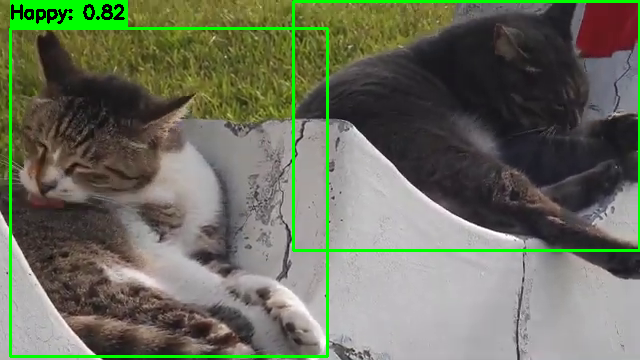

End of video.
Video analysis stopped.


In [7]:
# Make sure the models are loaded and the processing functions are defined
# by running the previous cells in your notebook first.

# Check if the video was downloaded successfully in the previous cell
if 'video_path' in locals() and video_path:
    print("\nStarting analysis on the downloaded YouTube video...")
    print("Press 'q' in the video window to stop the analysis.")
    
    # Call the analysis function with the path of the downloaded video
    analyze_video_file(video_path)
else:
    print("\nCannot start analysis because the video was not downloaded.")